# Numerical Methods for the GM model

We implemented 4 numerical methods to compute the solution for the **Gierer Meinhardt (GM)** model:

$$\frac{\partial u}{\partial t} = D_u (\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}) + \frac{\rho}{v} (\frac{u^2}{1+\kappa u^2}) - \mu_u u + \rho_u$$

$$\frac{\partial v}{\partial t} = D_v (\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}) + \rho (\frac{u^2}{1+\kappa u^2}) - \mu_v v$$

- Forward Euler Method

- Backward Euler Method

- Crank Nicolson Method

- Alternating Direction Implicit Method

For each method, we 

- computed the **evolution of the pattern** over time and visualized these patterns using 2D contour plot,

- saved the evolution of the pattern matrix's **mean deducted Frobenius norm** to gain an intuitive sense of the onset time of a stable pattern,

- and recorded the **runtime** of each method.

## Experiments Parameters Setup

```python
Ny, Nx = 40, 40 # length of each side of the entire grid
h = 2 # space step size, same in x and y direction
N = Nx * Ny # 1D length of the entire grid

Du = 0.02 # diffusion rate of u
Dv = 2 # diffusion rate of v
rho = 0.001 # source density
rho_u = 0.001 # basic activator production rate
mu_u = 0.02 # decay rate of u
mu_v = 0.03 # decay rate of v
kappa = 0.1 # saturation constanct

dt = 0.25 # time step size for forwared euler
dt = 20 # time step size for backward euler, CN, and ADI
end_t = 10000 # end time
time_steps = int(end_t / dt) # number of time steps of the entire evolution

U_init = np.random.normal(0.5, 0.1, (Ny, Nx)) # initial condition for u: random normal (mean=0.5, std=0.1)
V_init = 0.1 * np.ones((Ny, Nx)) # initial condition for v: all 0.1
```

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Forward Euler Method

dt = 0.25, time_steps = 40000
elapsed_clock_time = 11.244120121002197


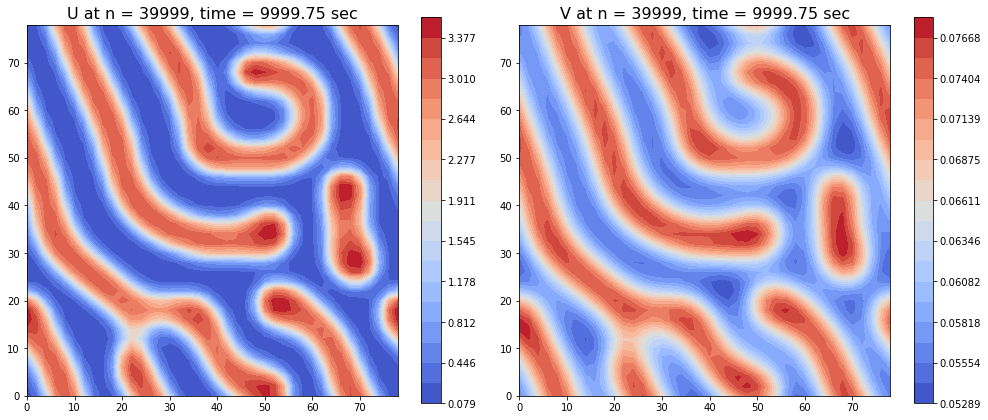

In [2]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 0.25
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Initial condition
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))

# Start timer
start = time.time()

# Generate pattern using own laplace function
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U[i - 1]-np.mean(U[i - 1])), ord='fro')
    V_norm_arr[i-1] = np.linalg.norm((V[i - 1]-np.mean(V[i - 1])), ord='fro')
    time_range[i-1] = (i-1) * dt
    
    U[i] = Du * c * my_laplacian(U[i - 1])
    V[i] = Dv * c * my_laplacian(V[i - 1])

    U[i] += dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - dt * mu_u) * U[i - 1] + dt * rho_u
    V[i] += dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - dt * mu_v) * V[i - 1]

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U[-1]-np.mean(U[-1])), ord='fro')
V_norm_arr[-1] = np.linalg.norm((V[-1]-np.mean(V[-1])), ord='fro')
time_range[-1] = (time_steps-1) * dt

plot_pattern(U, V, time_steps - 1, time_steps - 1, h, dt, filled=True)

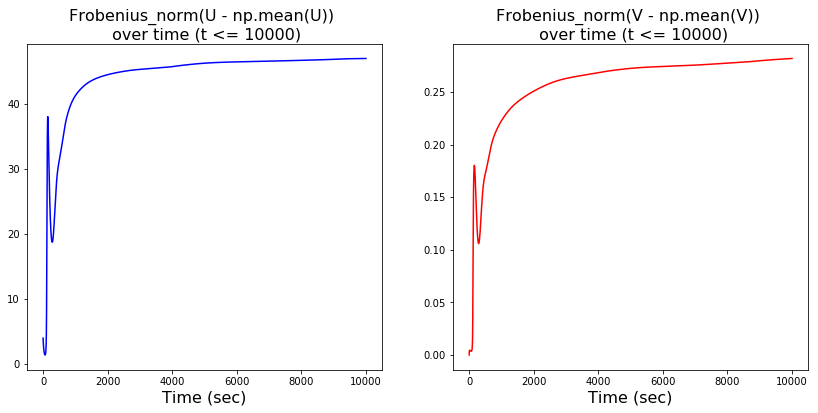

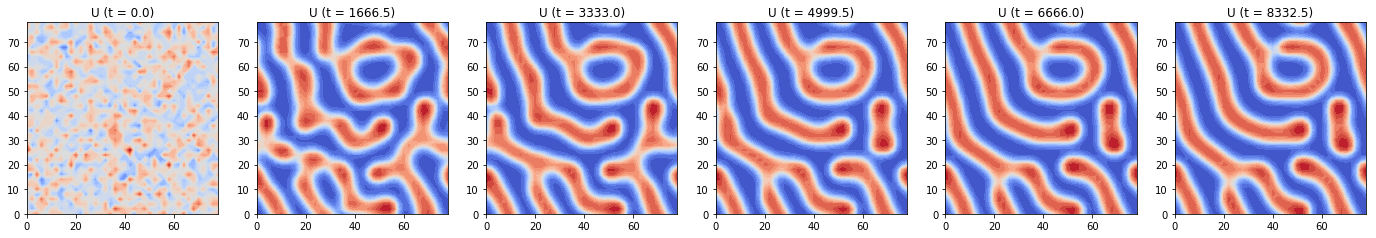

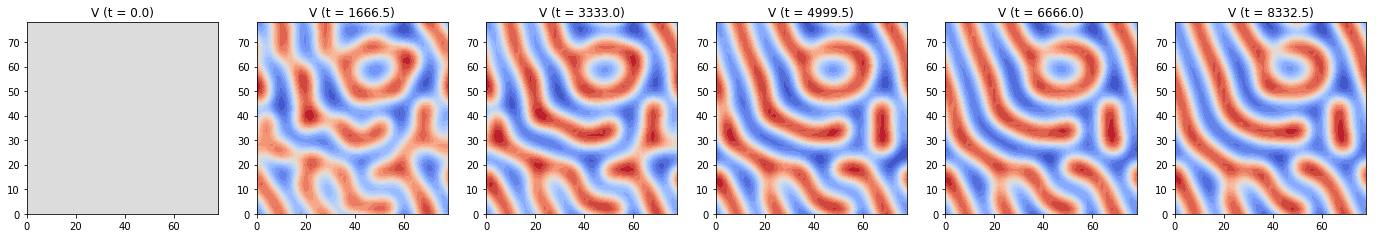

In [3]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

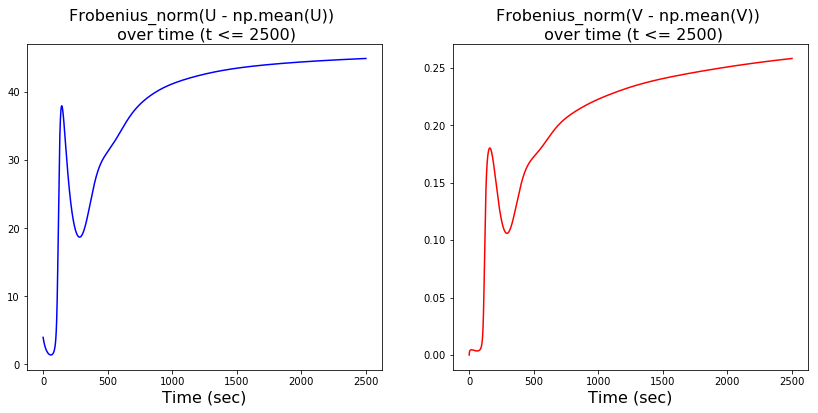

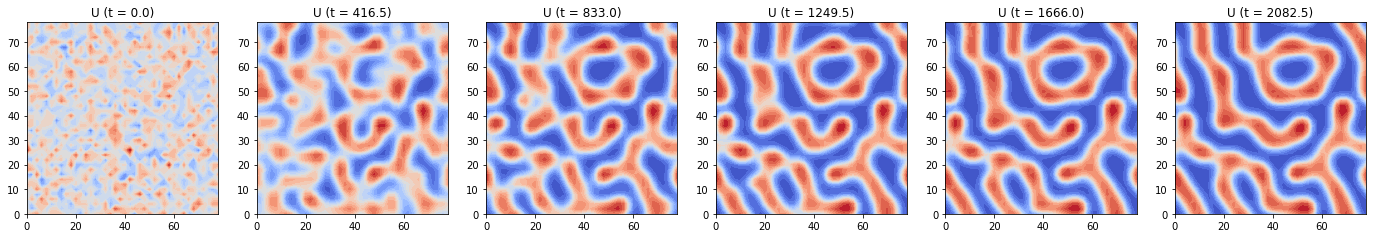

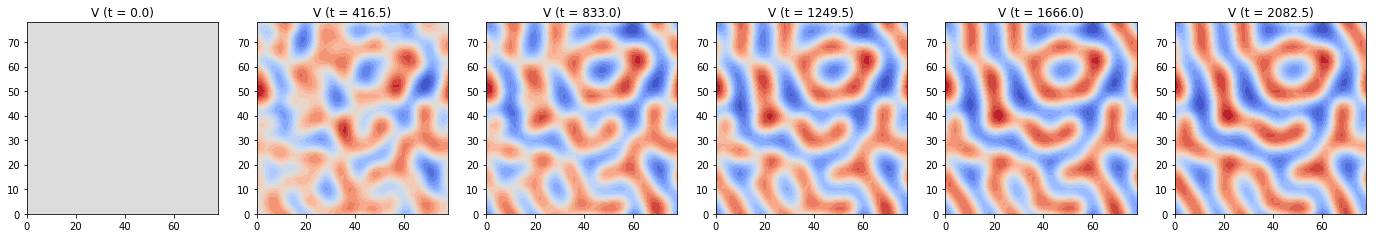

In [4]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 4, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=4, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=4, Nout=6)

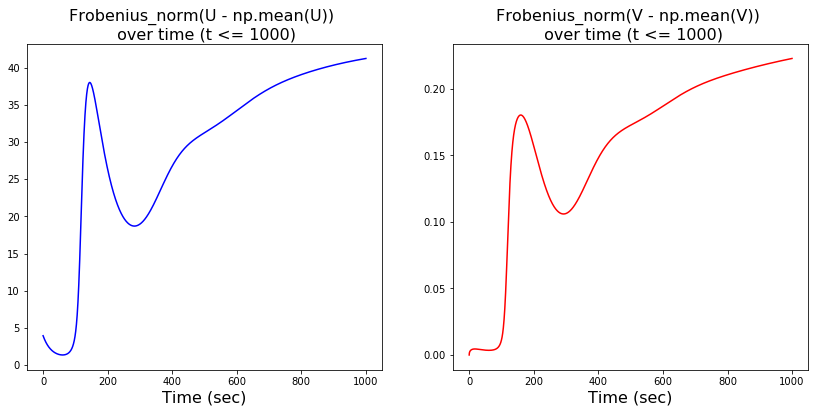

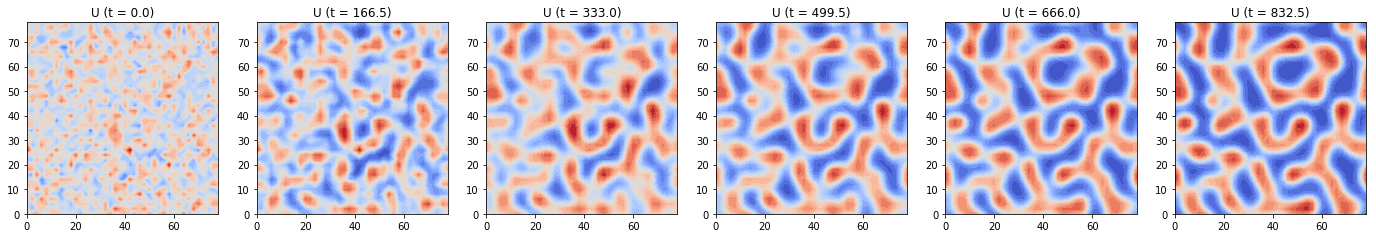

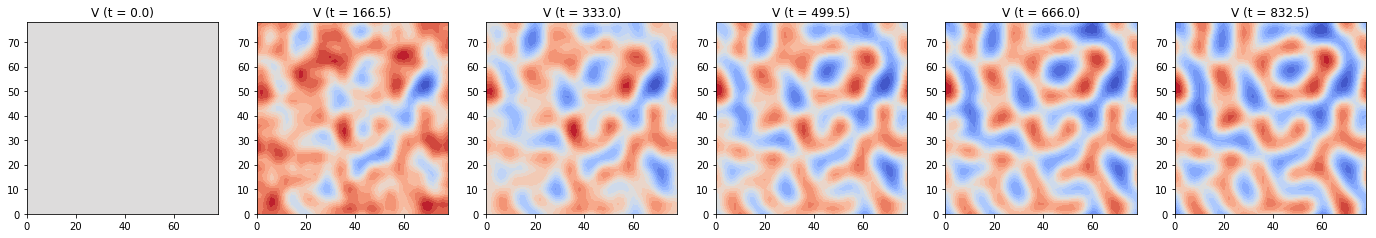

In [5]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 10, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=10, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=10, Nout=6)

## Backward Euler Method

dt = 20, time_steps = 500
elapsed_clock_time = 0.7361211776733398


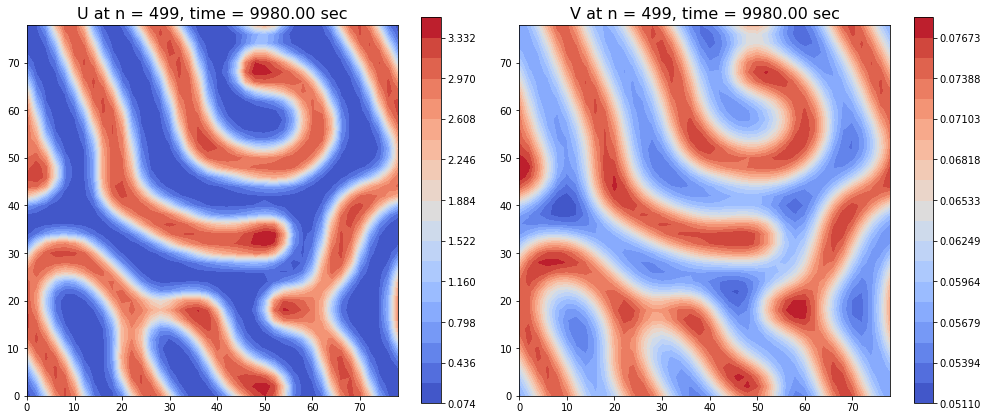

In [6]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct the transform matrix of U and V
# L = Laplace_matrix(Ny, Nx)
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - Du * c * L
Tv = sparse.eye(N) - Dv * c * L

# Factorize Tu, Tv
solve_Tu = linalg.factorized(Tu.tocsc())
solve_Tv = linalg.factorized(Tv.tocsc())

# Initial condition
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))


# Start timer
start = time.time()

# Backward Euler
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U1d[i - 1]-np.mean(U1d[i - 1])))
    V_norm_arr[i-1] = np.linalg.norm((V1d[i - 1]-np.mean(V1d[i - 1])))
    time_range[i-1] = (i-1) * dt
    
    bU = dt * rho/V1d[i - 1] * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_u) * U1d[i - 1] + dt * rho_u
    U1d[i] = solve_Tu(bU)

    bV = dt * rho * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_v) * V1d[i - 1]
    V1d[i] = solve_Tv(bV)

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U1d[-1]-np.mean(U1d[-1])))
V_norm_arr[-1] = np.linalg.norm((V1d[-1]-np.mean(V1d[-1])))
time_range[-1] = (time_steps-1) * dt

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

plot_pattern(U2d, V2d, time_steps-1, time_steps-1, h, dt, filled=True)

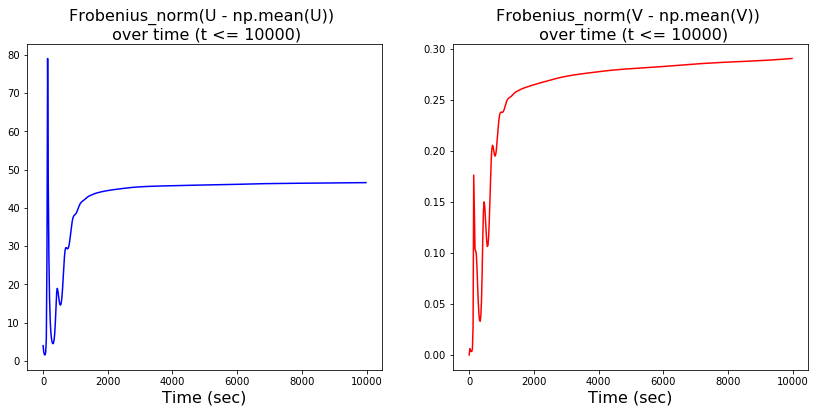

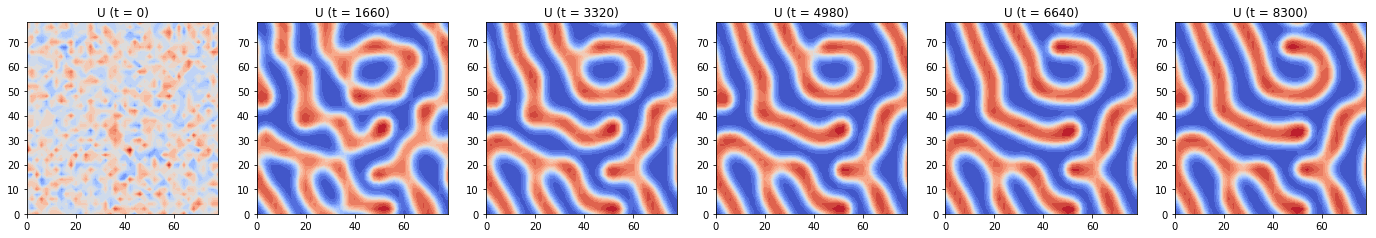

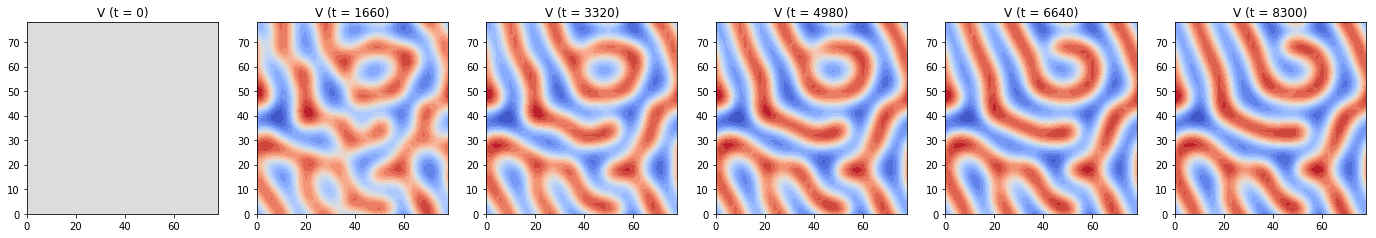

In [7]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=1, Nout=6)

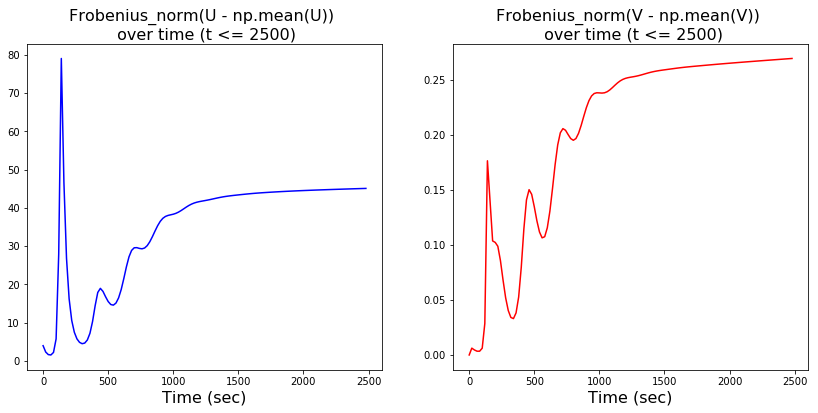

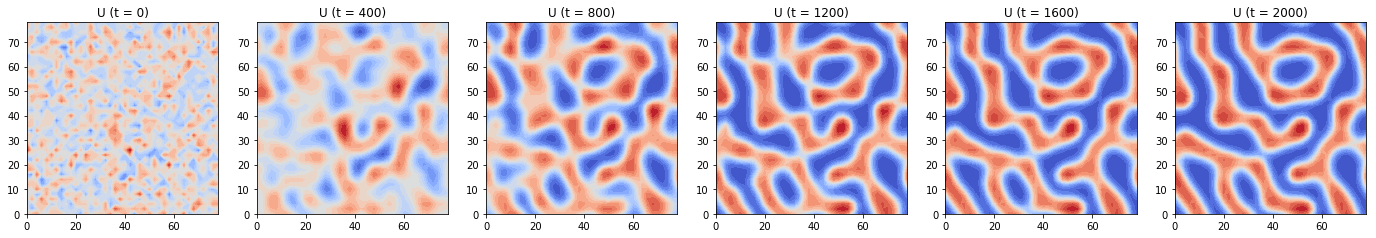

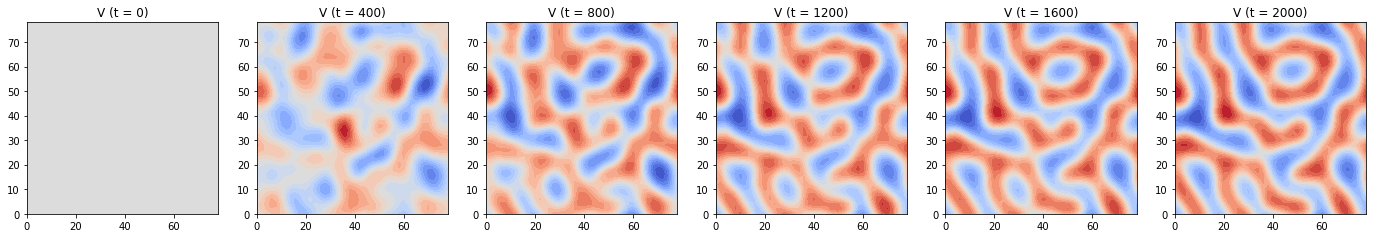

In [8]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 4, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=4, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=4, Nout=6)

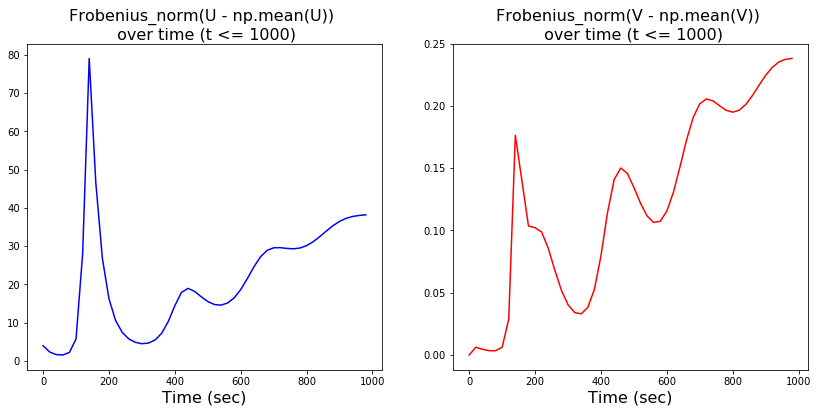

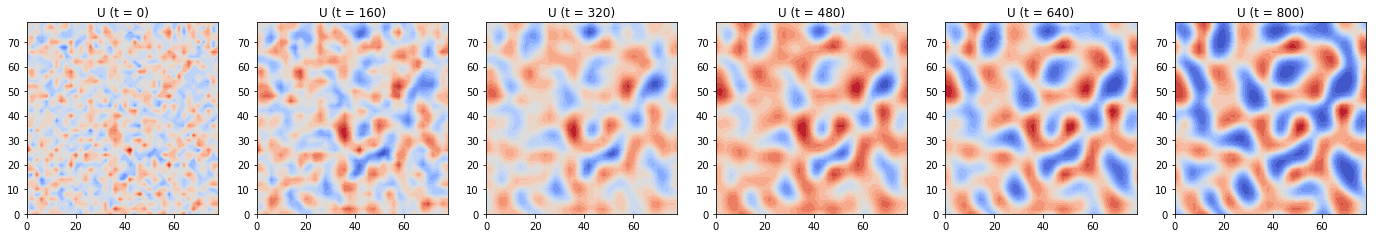

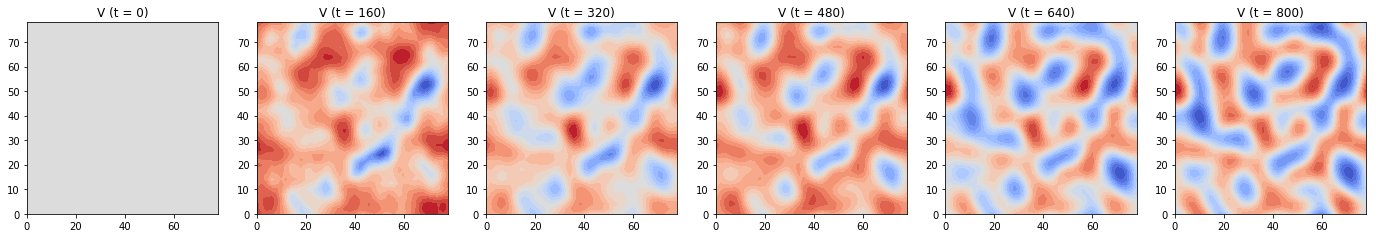

In [9]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 10, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=10, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=10, Nout=6)

## Crank Nicolson Method

dt = 20, time_steps = 500
elapsed_clock_time = 0.8287942409515381


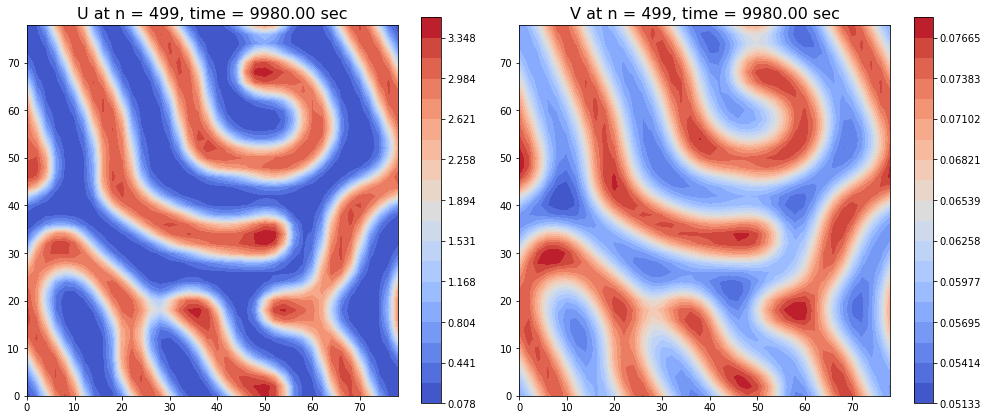

In [10]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)


# Construct the transform matrix of U and V
# L = Laplace_matrix(Ny, Nx)
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - 0.5 * Du * c * L
Tv = sparse.eye(N) - 0.5 * Dv * c * L

# Factorize Tu, Tv
solve_Tu = linalg.factorized(Tu.tocsc())
solve_Tv = linalg.factorized(Tv.tocsc())

# Initial condition
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))

# Start timer
start = time.time()

# CN Method
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U1d[i - 1]-np.mean(U1d[i - 1])))
    V_norm_arr[i-1] = np.linalg.norm((V1d[i - 1]-np.mean(V1d[i - 1])))
    time_range[i-1] = (i-1) * dt
    
    bU = (0.5 * Du * c) * L.dot(U1d[i - 1]) \
    + dt * rho/V1d[i - 1] * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_u) * U1d[i - 1] + dt * rho_u
    U1d[i] = solve_Tu(bU)

    bV = (0.5 * Dv * c) * L.dot(V1d[i - 1]) \
    + dt * rho * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_v) * V1d[i - 1]
    V1d[i] = solve_Tv(bV)

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U1d[-1]-np.mean(U1d[-1])))
V_norm_arr[-1] = np.linalg.norm((V1d[-1]-np.mean(V1d[-1])))
time_range[-1] = (time_steps-1) * dt

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

plot_pattern(U2d, V2d, time_steps-1, time_steps-1, h, dt, filled=True)

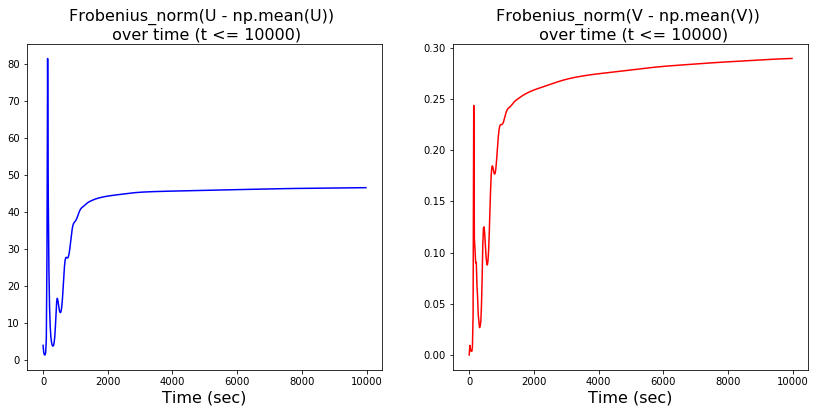

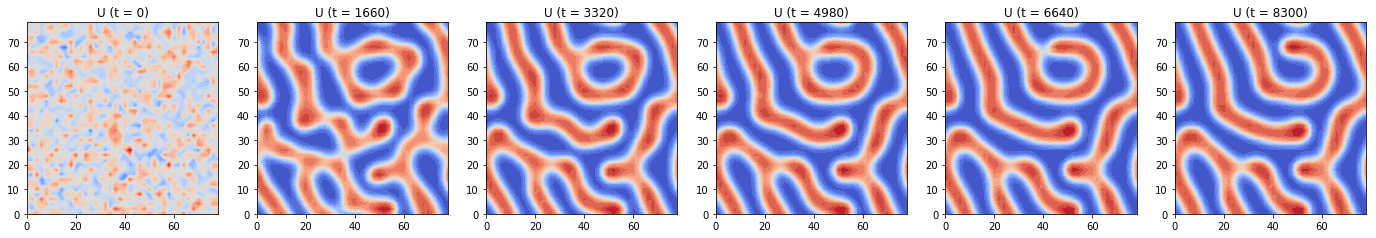

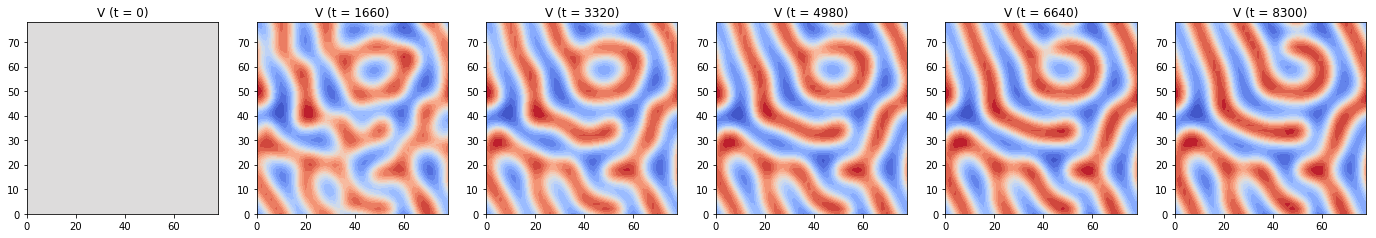

In [11]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=1, Nout=6)

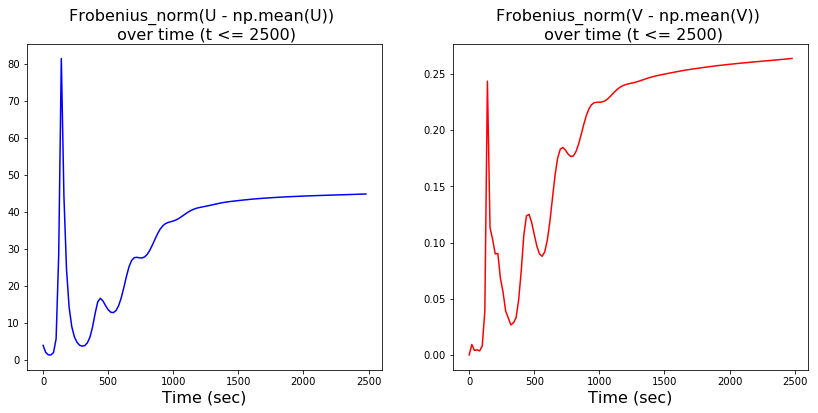

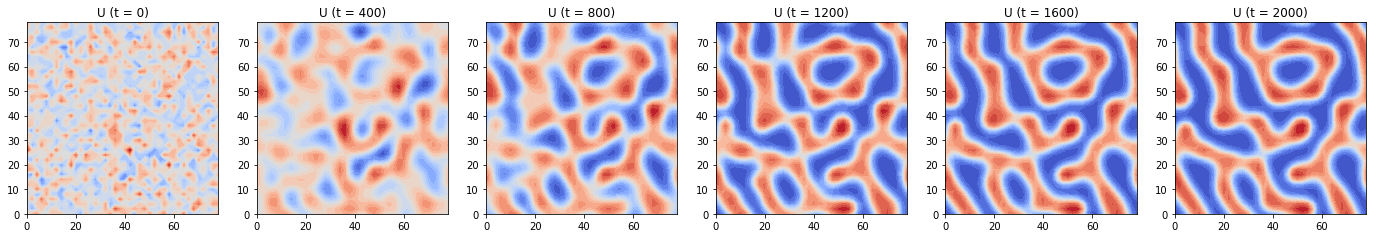

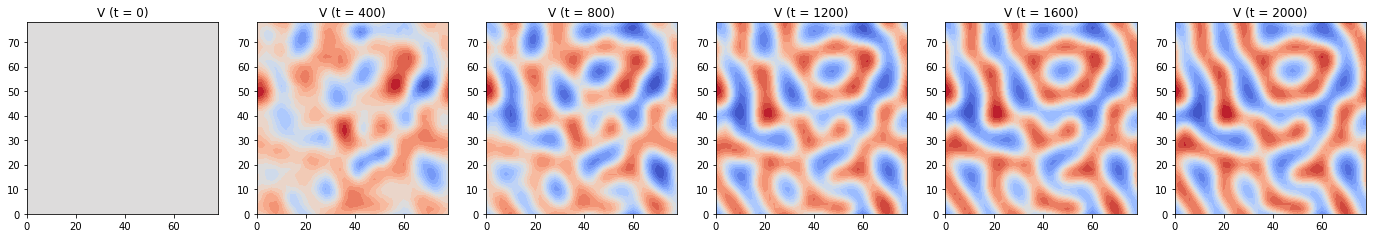

In [12]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 4, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=4, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=4, Nout=6)

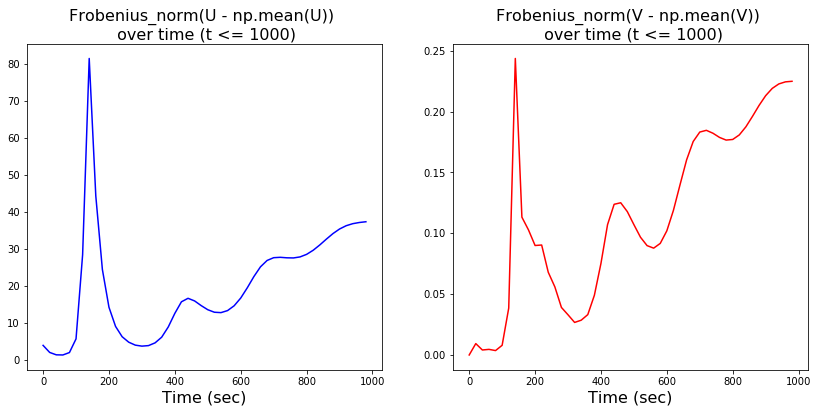

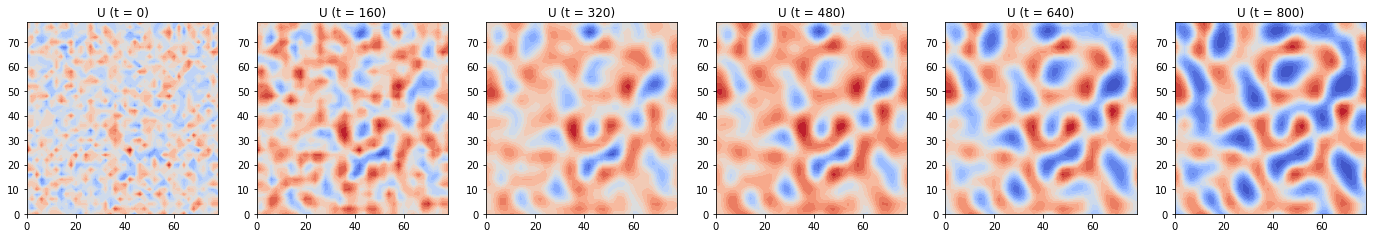

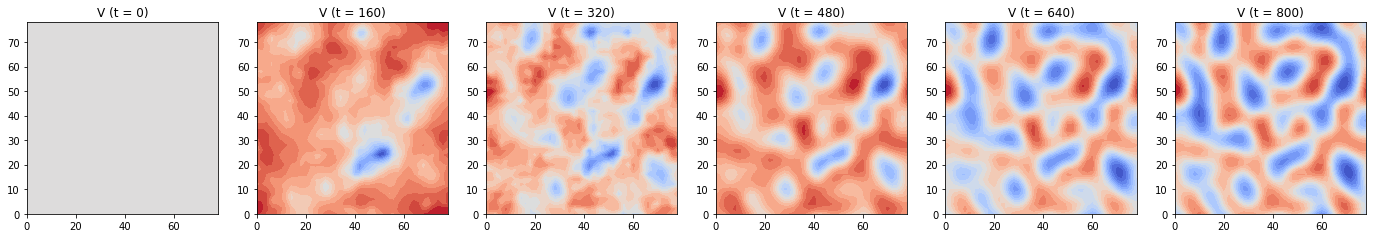

In [13]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 10, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=10, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=10, Nout=6)

## Alternating Direction Implicit Method

dt = 20, time_steps = 500
elapsed_clock_time = 0.9569821357727051


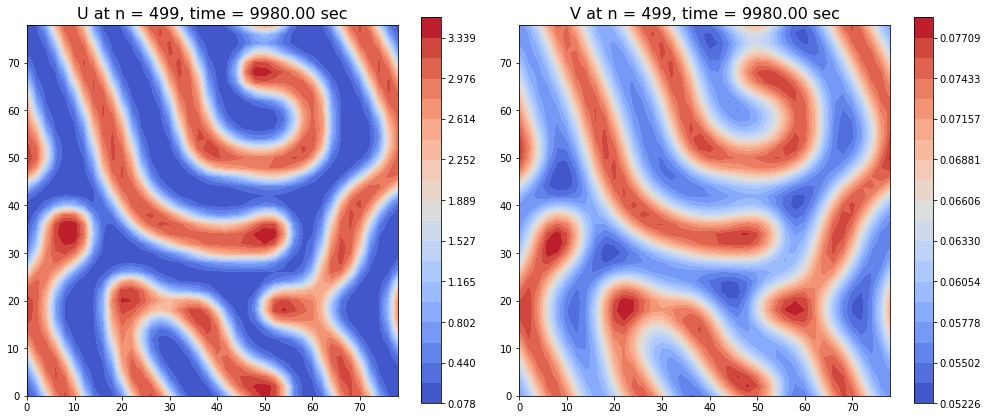

In [14]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)


# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial condition
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))

# Start timer
start = time.time()

# Generate pattern
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U[i - 1]-np.mean(U[i - 1])), ord='fro')
    V_norm_arr[i-1] = np.linalg.norm((V[i - 1]-np.mean(V[i - 1])), ord='fro')
    time_range[i-1] = (i-1) * dt
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
        + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
        + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U[-1]-np.mean(U[-1])), ord='fro')
V_norm_arr[-1] = np.linalg.norm((V[-1]-np.mean(V[-1])), ord='fro')
time_range[-1] = (time_steps-1) * dt

plot_pattern(U, V, time_steps-1, time_steps-1, h, dt, filled=True)

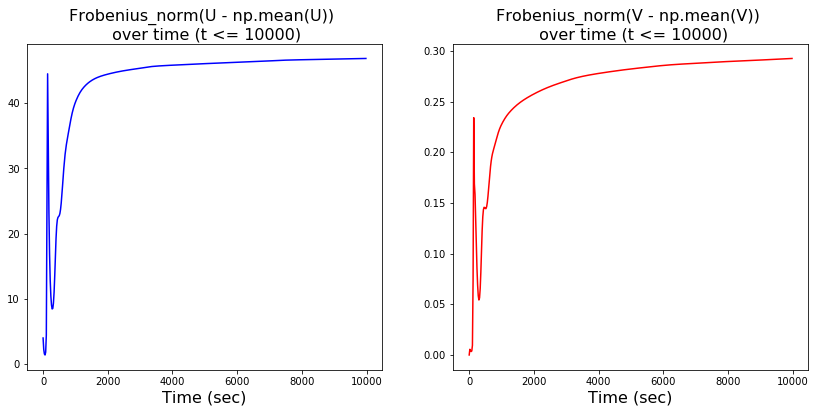

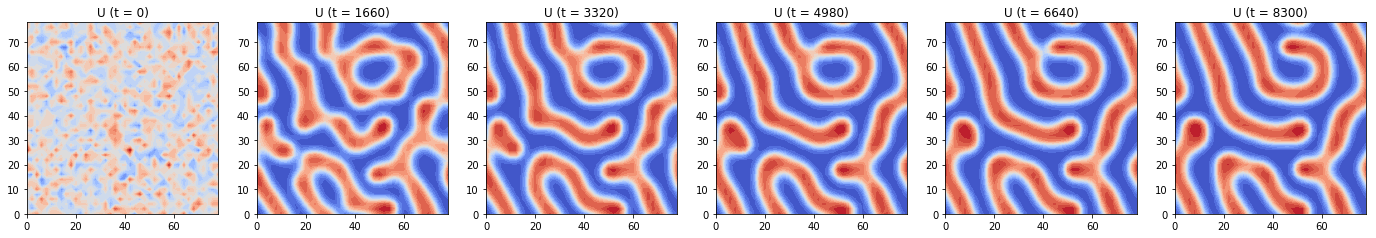

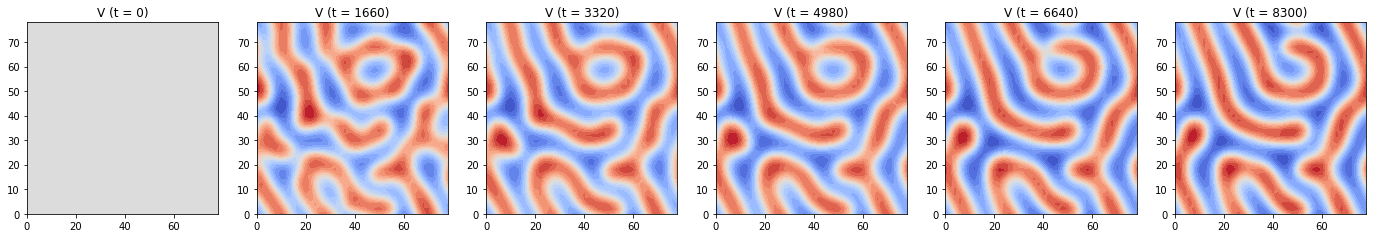

In [15]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

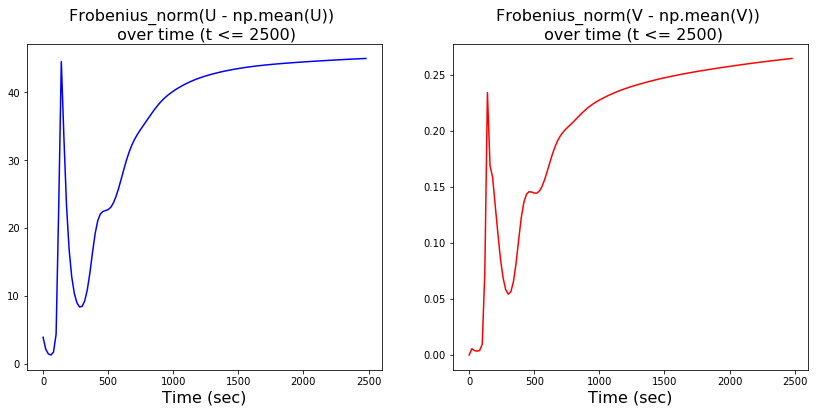

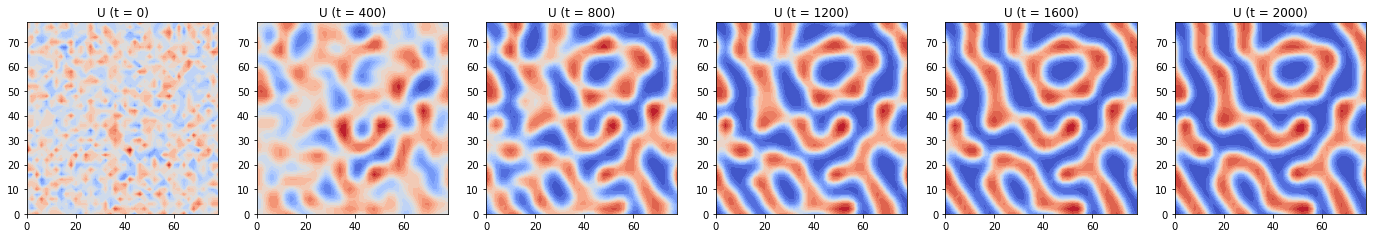

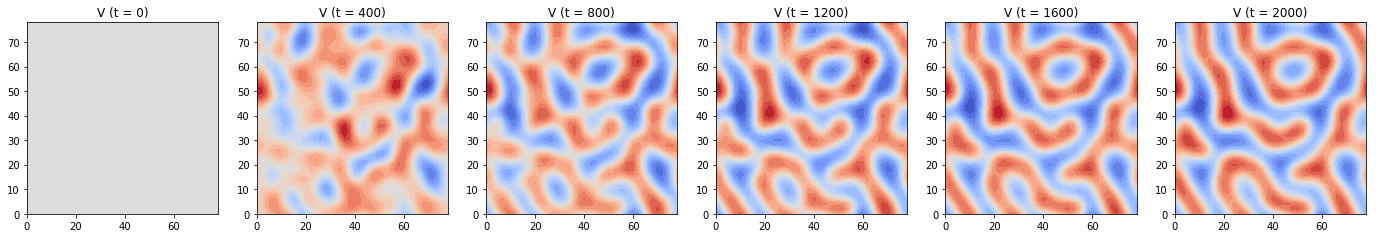

In [16]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 4, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=4, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=4, Nout=6)

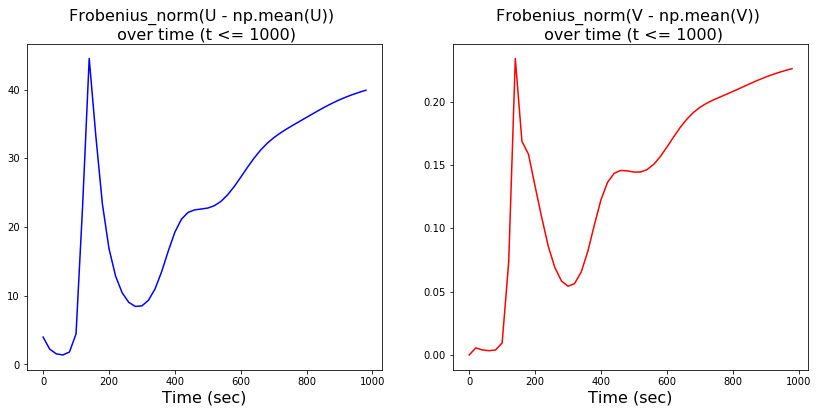

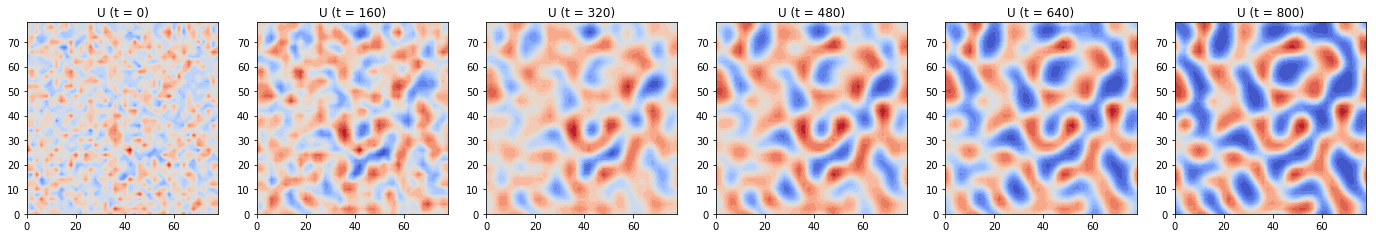

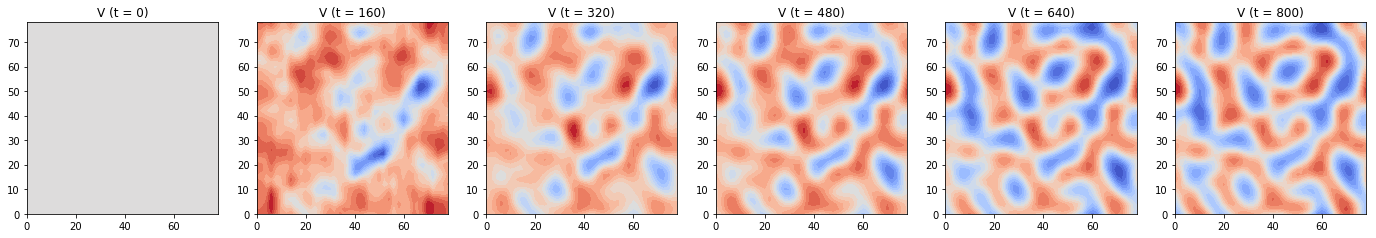

In [17]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 10, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=10, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=10, Nout=6)

## Summary

### Pattern Formation
We used each method to compute the solution pattern matrix, printed its runtime, plotted the pattern at the ending state, and also showed the evolution of the mean deducted Frobenius norm of U and V. We found that for the **GM** model, the evolution of patterns and their ending states look similar among different methods, while their mean deducted Frobenius norm changed differently over time. The norm firstly grows and peaks before t=200(s). For each method, the norm slowed down its growth after t=1000(s) and reached a stable state after t=2500(s). Thus, we also plotted the evolution of the patterns before t=1000(s) and t=2500(s) to gain a more detailed sense of the pattern's formation process. 

### Numerical Stability and Runtime Analysis
The explicit Forward Euler method is expected to have the smallest limit for time step size ($dt \leq \frac{h^2}{4 \text{max}(D_u, D_v)}$), while the other 3 partially implicit (implicit for diffusion term and explicit for reaction terms) methods are expected to have larger limit for dt. We **numerically checked the limit of time step size (dt)** for each method. The results are summarized in the following table. The results matched our expectation. The explicit Foward Euler method has the most rigorous limit (max(dt)=0.45), the other three implicit methods allow dt to be much larger (max(dt)>40). Since we used much larger dt in implicit methods than in the Forward Euler method, the runtimes of three implicit methods are much shorter than that of Forward Euler. We expect the runtime of the ADI method to be the shortest among all implicit methods since it solves a smaller matrix of tridiagonal form. But as we did not use a fast enough solver (i.e, the [tridiagonal matrix algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)) and the size of the grid (40 X 40) is not too large, the actual runtime of the ADI method is a little bit longer than Backward Euler and Crank Nicolson method.


|        Method       |  Runtime  | Stability limit for dt | 
|---------------------|-----------|------------------------|
| Forward Euler       |  11.244   |    0.45                |
| Backward Euler      |   0.736   |     42                 |
| Crank Nicolson      |   0.828   |     44                 |
| ADI method          |   0.957   |     64                 |
